In [1]:
#| default_exp DDPM

In [2]:
#| hide
from nbdev.showdoc import *
import nbdev; nbdev.nbdev_export()

# Denoising Diffusion Probabilistic Models

> In this notebook, I will illustrate the implementation of various components of [Denoising Diffusion Probabilistic Models](https://hojonathanho.github.io/diffusion/) using the MNIST dataset. Additionally, I will showcase the generation of images from the MNIST dataset.

![Generated output on MNIST](./images/output_benign.gif)

## What is diffusion?
![Ink drop in a water](./images/ink_drop.jpg)

Diffusion process : A diffusion process is stochastic markov process having continuous sample path. A process of moving from **Complex Distribution** to **Simple Distribution**. It has following properties: 



- Stochastic
- Markov Chain
- Continuous sample path. 

## What is DDPM? 
Denoising Diffusion Probabilistic Models, DDPM in short, a paper by Jonathan Ho et al, defines a new class of generative models. Diffusion Models belong to the category of generative models, which are utilized to produce data resembling the training dataset. In essence, Diffusion Models operate by perturbing training data with incremental Gaussian noise and subsequently learning to reconstruct the original data by reversing this noise-induced degradation. Post-training, the Diffusion Model can be employed to generate data by feeding randomly sampled noise through the acquired denoising mechanism.

We can devide DDPM into two main components:

- Forward/diffusion Process
- Reverse/Sampling Process

## What is forward/diffusion process?

As stated previously, a Diffusion Model involves a forward process, also known as a diffusion process, where a data point, typically an image, undergoes incremental noise addition. We perform this by using a Linear Noise Scheduler. 

Considering a data point sampled from a genuine data distribution as $\mathbf{x}_0 \sim q(\mathbf{x})$, we introduce the concept of a "forward diffusion process." In this process, Gaussian noise is incrementally added to the initial sample over $T$ steps, resulting in a series of noisy samples denoted as $\mathbf{x}_1, \dots, \mathbf{x}T$. The magnitude of each step is determined by a variance schedule denoted as ${\beta_t \in (0, 1)}{t=1}^T$
$$
q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})
$$

A nice property of the above diffusion process is that we can sample $\mathbf{x}_t$ from $\mathbf{x}_0$ using the equation: 

\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}

where: 
$\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$


In [5]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import sys
from tqdm.auto import tqdm
from torchvision.utils import make_grid
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Noise Scheduler

We will start by implementing the basic building block of DDPM with Noise Scheduler. It takes in num of timesteps, beta_start and beta_end as input. It returns a noised image at timestep t.
Our Noise Scheduler class will have three components:


- __init__(): This will pre-compute and store all the coefficient related to $\alpha_{t}$ and others.
- __add_noise__(): This corresponds to forward process. 
- __sample_prev_timestep__(): This is for reverse process and we will discuss it in later stage of this notebook. 

In [6]:
class LinearNoiseScheduler():
    def __init__(self, num_timesteps, beta_start, beta_end):
        pass
    def add_noise(self, original, noise, t):
        pass
    def sample_prev_timestep(self, xt, t, noise_pred):
        pass

Add Noise and Init function

In [7]:
class LinearNoiseScheduler():
    '''Inspired from: https://github.com/explainingai-code/DDPM-Pytorch'''
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.betas = self.betas.to(device)
        self.alphas = 1 - self.betas
        self.alphas_cum_prod = torch.cumprod(self.alphas, 0)
        self.sqrt_alphas_cum_prod = torch.sqrt(self.alphas_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alphas_cum_prod)

    def add_noise(self, original, noise, t):
        original_shape = original.shape
        batch_size = original_shape[0]

        sqrt_alpha_cum_prod = self.sqrt_alphas_cum_prod[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)

        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        return sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise.to(original.device)
    
    def sample_prev_timestep(self, xt, t, noise_pred):
        pass

We can look at the values of alphas, betas and other for better understanding. As we have implemented linear scheduler, the value of $\alpha$ decrease with time which when looked in perspective of forward equation as mentioned earlier means that original image is decaying. While increasing value of $\beta$ show increase in gaussian noise component. 

Text(0.5, 1.0, 'Sqrt One Minus Alpha Cum Prod')

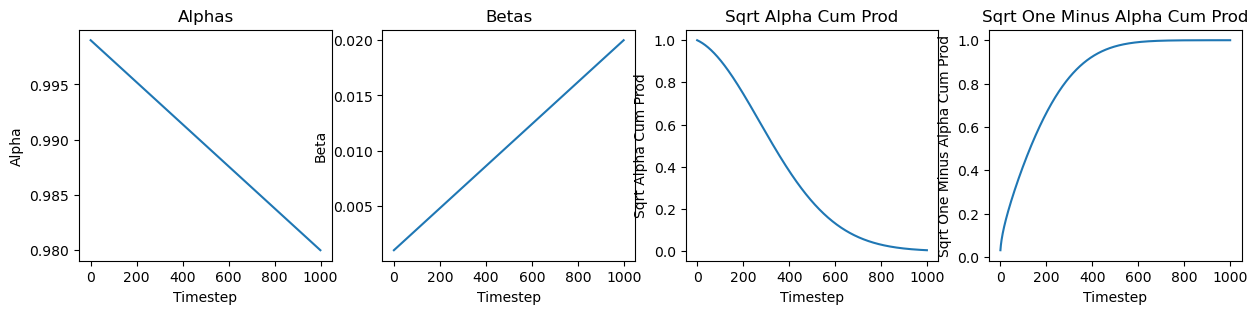

In [8]:
linear_scheduler = LinearNoiseScheduler(1000, 0.001, 0.02)

plt.figure(figsize=(15,3))
plt.subplot(1,4,1)
plt.plot(linear_scheduler.alphas.cpu())
plt.xlabel('Timestep')
plt.ylabel('Alpha')
plt.title('Alphas')

plt.subplot(1,4,2)
plt.plot(linear_scheduler.betas.cpu())
plt.xlabel('Timestep')
plt.ylabel('Beta')
plt.title('Betas')

plt.subplot(1,4,3)
plt.plot(linear_scheduler.sqrt_alphas_cum_prod.cpu())
plt.xlabel('Timestep')
plt.ylabel('Sqrt Alpha Cum Prod')
plt.title('Sqrt Alpha Cum Prod')

plt.subplot(1,4,4)
plt.plot(linear_scheduler.sqrt_one_minus_alpha_cum_prod.cpu())
plt.xlabel('Timestep')
plt.ylabel('Sqrt One Minus Alpha Cum Prod')
plt.title('Sqrt One Minus Alpha Cum Prod')

Deffusion process on 2D image. 

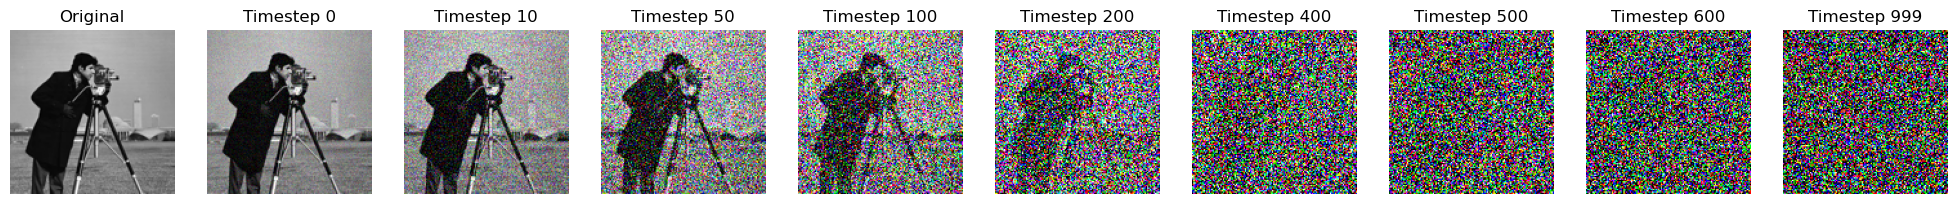

In [14]:
test_img = Image.open("./images/cameraman.jpg")
test_img = test_img.resize((128, 128))
test_img = transforms.ToTensor()(test_img).unsqueeze(0)
test_img = test_img.to(device)
step = [0, 10, 50, 100, 200, 400, 500, 600,999]
plt.figure(figsize=(25,15))
plt.subplot(1,10,1)
plt.imshow(np.transpose(test_img[0].cpu().numpy(), (1,2,0)))
plt.title('Original')
plt.axis('off');
for i, j in enumerate(step):
    plt.subplot(1,10,i+2)
    noise = torch.randn_like(test_img)
    test_img_noisy = linear_scheduler.add_noise(test_img, noise, j)
    plt.imshow(np.transpose(torch.clamp(test_img_noisy[0], 0, 1).cpu().numpy(), (1,2,0)))
    plt.axis('off');
    plt.title(f'Timestep {j}')